# Created MindfulSession table and includes whether endtime was within 30 mins either way of sleep



In [5]:
import pandas
import psycopg2
from configparser import ConfigParser
import numpy 
path = 'C:/Users/tonyr/Desktop/Self Education/Production Files/apple_health_export/'
import os
prodfiles = 'C:/Users/tonyr/desktop/Self Education/Production Files/'
os.chdir(prodfiles)


class data_analysis():


    def __init__(self):
        self = self
        
    def config(self,filename='database.ini', section='postgresql'):
        parser = ConfigParser()
        parser.read(filename)    
        db = {}
        if parser.has_section(section):
            params = parser.items(section)
            for param in params:
                db[param[0]] = param[1]
        else:
            raise Exception('Section {0} not found in the {1} file'.format(section, filename))
        return db

    def connect(self,table):
        DF = pandas.DataFrame()
        """ Connect to the PostgreSQL database server """
        conn = None
        try:
            command = """
            Select * from """ + table + """
            """
            params = self.config(filename='database.ini', section='postgresql')
            conn = psycopg2.connect(**params)
            cur = conn.cursor()
            cur.execute(command)
            colnames = [desc[0] for desc in cur.description]
            DF = pandas.DataFrame(cur.fetchall())
            DF.columns = colnames
        except (Exception, psycopg2.DatabaseError) as error:
            print(error)
        finally:
            if conn is not None:
                conn.close()
            return DF

    def mindfulg(self):
#         path = 'C:/Users/tonyr/Desktop/Self Education/Production Files/apple_health_export/'
        d = self.connect('mindfulwithsleepanalysis')
        mindfulgrouped = d.groupby(['TheDate','endedWithinThirtyMinsOfSleeping'],as_index=False)['unithours'].sum()
        return mindfulgrouped

    def changeMeditationValues (self,row):
        if row['endedWithinThirtyMinsOfSleeping'] == 1 :
            return 'Meditation Ended Within 30 Minutes of Sleeping'            
        elif row['endedWithinThirtyMinsOfSleeping'] == 0:
            return 'Mediation Ended More than 30 Minutes before Sleeping'

    def sleep(self):
        path = 'C:/Users/tonyr/Desktop/Self Education/Production Files/apple_health_export/'
        sleep = pandas.read_csv(path + 'Grouped/grouped_SleepAnalysis.csv')[['sum','TheDate']]
        sleep = sleep.rename(columns={"sum": "SleepTime", "TheDate": "SleepDate"})
        sleep['SleepDate'] = pandas.to_datetime(sleep['SleepDate'])
        sleep['Sleep_Rolling_ThreeSum'] = sleep['SleepTime'].rolling(window=3).sum().fillna(0)
        sleep['Sleep_Rolling_ThreeDayAverage'] = sleep['SleepTime'].rolling(window=3).mean().fillna(0)
        sleep['Sleep_Rolling_FiveDayAverage'] = sleep['SleepTime'].rolling(window=5).mean().fillna(0)
        sleep = sleep[sleep['SleepDate']  > '2019-07-01'] 
        sleep.sort_values(by=['SleepDate'], inplace = True)
        sleep.set_index('SleepDate', inplace=True)
        return sleep

    def meditation(self):
        meditation = self.mindfulg()
        # meditation = pandas.read_csv('Grouped/grouped_MindfulSession.csv')[['sum','TheDate','endedWithinThirtyMinsOfSleeping']]
        meditation = meditation.rename(columns={"unithours": "MeditationTime", "TheDate": "MeditationDate"})
        # lambda x: x
        meditation.sort_values(by=['MeditationDate'], inplace = True)
        meditation.set_index('MeditationDate', inplace=True)
        return meditation

    def sm(self):
        sleep = self.sleep()
        meditation = self.meditation()
        sm = sleep.join(meditation,lsuffix='_sleep', rsuffix = '_meditation').fillna(0)
        sm = sm[sm['SleepTime'] > 1]
        sm['MeditationCategorical'] =  numpy.where(sm['MeditationTime'] == 0, 0 , 1)
        sm['MeditationCategorical_Rolling_ThreeSum'] = sm['MeditationCategorical'].rolling(window=3).sum().fillna(0)
        sm['MeditationCategorical_Rolling_FiveSum'] = sm['MeditationCategorical'].rolling(window=5).sum().fillna(0)
        sm['Meditation_Rolling_ThreeSum'] = sm['MeditationTime'].rolling(window=3).sum().fillna(0)
        sm['Meditation_Rolling_FiveSum'] = sm['MeditationTime'].rolling(window=5).sum().fillna(0)
        sm['Meditation_Rolling_ThreeDayAverage'] = sm['MeditationTime'].rolling(window=3).mean().fillna(0)
        sm['Meditation_Rolling_FiveDayAverage'] = sm['MeditationTime'].rolling(window=5).mean().fillna(0)
        sm['endedWithinThirtyMinsOfSleeping'] = sm.apply(lambda row: self.changeMeditationValues(row), axis=1)
        return sm

if __name__ == '__main__':
    path = 'C:/Users/tonyr/Desktop/Self Education/Production Files/apple_health_export/'
    a = data_analysis()
    sm = a.sm()
    sleephappy = a.connect('sleephappy')
    sleephappy.to_csv(prodfiles + 'sleephappy.csv',index =False)
    heartrate = a.connect('heartratecompare')
    heartrate_concat = a.connect('heartratecompareconcat')
    heartrate_concat.to_csv(prodfiles + 'heartratecompare_concat.csv',index = False)
    calories_burned = a.connect('caloriesburned')
    calories_burned.to_csv(prodfiles + 'caloriesburned.csv', index = False)
    mindfulgrouped = a.mindfulg().groupby(['TheDate','endedWithinThirtyMinsOfSleeping'],as_index=False)['unithours'].sum()

AttributeError: 'AxesSubplot' object has no attribute 'shape'

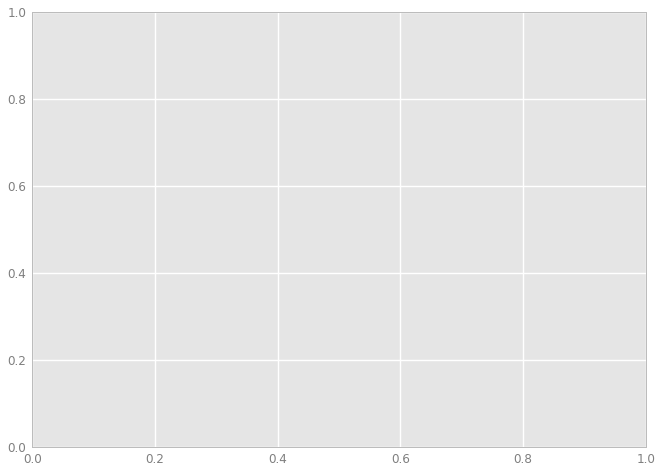

In [7]:
import ggplot
from ggplot import *
# 1 means ended within 30 mins of sleep


gg33 = ggplot(sm[sm['SleepTime'] > 1].iloc[2:100,0:100], aes(
    'Meditation_Rolling_ThreeSum','Sleep_Rolling_ThreeSum')) + geom_point(
    ) + ggtitle("Sleep Vs Meditation") + xlab("3 Day Meditation Total") + ylab(
    "3 Day Sleep Total") + facet_wrap("endedWithinThirtyMinsOfSleeping")
gg33.show()

gg35 = ggplot(sm[sm['SleepTime'] > 1].iloc[2:100,0:100], aes(
    'Meditation_Rolling_ThreeSum','Sleep_Rolling_ThreeDayAverage')) + geom_point(
    ) +  xlab("3 Day Meditation Total") + ylab(
    "3 Day Sleep Average") + facet_wrap("endedWithinThirtyMinsOfSleeping")
gg35.show()


gg33.save(filename = 'Three Day Meditaion Vs 3 Day Sleep Sum.png')
gg35.save(filename = 'Three Day Meditaion Vs 3 Day Sleep Average.png')